# House Prices - Advanced Regression Techniques
## Predict sales prices and practice feature engineering, RFs, and gradient boosting

Ser capaz de predecir el precio de una vivienda a partir de una base de datos que contiene 79 variables las que describen (casi) todo aspecto de las residencias en **Ames, Iowa**.

In [1]:
# CARGAR LAS LIBRERIAS BÁSICA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Se cargan los archivos básicos
df_total = pd.read_csv('../data/train.csv')

## Exploratory Data Analysis

In [3]:
# Cantidad de variables y observaciones
df_total.shape

(1460, 81)

In [7]:
# Información básica sobre los datos almacenados
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [28]:
# No falta ningún valor de iD y al tratarse de solo un identificador 
# lo retiramos del análisis y asignamos como index
df_total.set_index('Id', inplace=True)

Respecto al tipo de datos almacenados, se observa como la mayoría son considerados tipo 'object', los cuales podrían ser cadenas de caracteres o tipos numéricos con algunos datos faltantes.

Por otro lado se ve que varias de las variables presentan datos faltantes. En algunos casos la cantidad de datos faltantes son menores, en otros comprenden la mayoría se la columna. Para ilustrar esto se grafíca la columna con los datos faltantes.

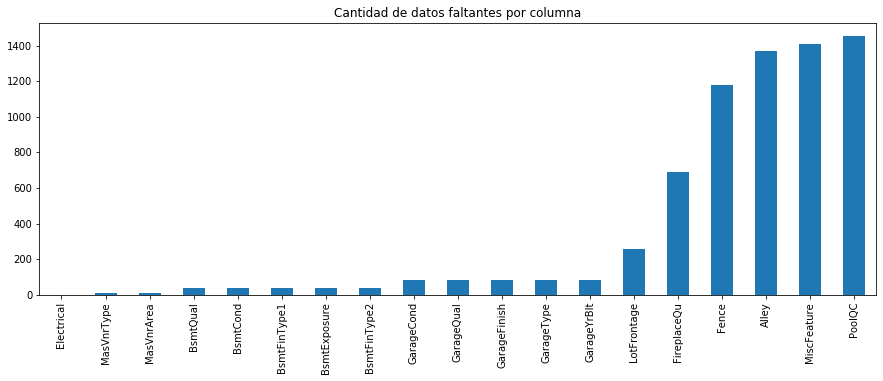

In [38]:
df_total.isnull().sum()[df_total.isnull().sum() != 0].sort_values().plot(kind='bar', figsize=(15,5),
                                                                        title = 'Cantidad de datos faltantes por columna');

A continuación estudiamos un poco más a fondo las variables que presentan datos faltantes y se evalúa si existe alguna forma de completar estos datos o 

Partiendo por las variables con mayor cantidad de datos faltantes:
- PoolIQC: Calidad de la piscina. Variable categórica de 4 niveles + 1 para definir la calidad de la piscina. En caso de que la casa no tenga piscina el valor es NA (el quinto nivel de la categoría). 
- MiscFeature: Caracteristicas miscelaneas que no entran en las otras columnas. Al igual que PoolIQC uno de los niveles está definido como NA.
- Alley: Tipo de acceso a un Alley. En caso de no existir se usa NA.
- Fence: Calificador de la calidad de la cerca. En caso de no existir cerca se usa NA.
- FireplaceQu: Calidad de la chimenea. Se usa NA en caso de no tener.
- LotFrontage: pies lineales de calle conectados con la propiedad. Supongo que un valor de NA se traduce en un cero.

...

Varias de las columnas que tienen NA es debido a que es uno de los valores establecidos como nivel de la categoría. Debo averiguar si esto puede afectar en algo los algoritmos o no. Puede que lo mejor sea reemplazar este por un valor más normal.


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [12]:
df_total.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [13]:
len(df_total.columns)

81

Como se puede ver inicialmente contamos con 81 variables en total, de las cuales:
- 1 variable objetivo: SalePrice
- 37 variables numéricas
- 43 variables categoricas

La alta cantidad de variables categóricas cada una con múltiples niveles puede dificultar el tratamiento de la base si siguimos la vía de tratarlas como variables dummy. Se hace necesario hacer una selección de variables y (eventualmente) una ingeniería de variables para reducir este número disminuyendo la perdida de la información.

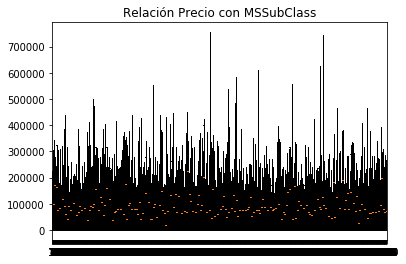

In [23]:
fig1, ax1 = plt.subplots()
ax1.set_title('Relación Precio con MSSubClass')
ax1.boxplot(df_total.loc[:, ['MSSubClass', 'SalePrice']])
plt.show()

In [22]:
plt.show()